In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Reshape, Dropout, RNN, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import swats
import gc 

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
def nextPowerTwo(n):
    n = n-1
    n = n >> 1 | n
    n = n >> 2 | n
    n = n >> 4 | n
    n = n >> 8 | n
    n = n >> 16 | n
    n = n+1
    return(n)

In [3]:
drv.init()
mod=SourceModule("""
__global__ void cuda_add(double *a,double *c, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=a[i];
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_add1=mod.get_function("cuda_add")

In [4]:
drv.init()
mod=SourceModule("""
__global__ void cuda_mean(double *a, double *c, double *d, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=a[i]*d[i];
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_mean1=mod.get_function("cuda_mean") 

In [5]:
drv.init()
mod=SourceModule("""
__global__ void cuda_var1(double *a,double b, double *c,double *d, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=(a[i]-b)*(a[i]-b)*d[i];
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_var1=mod.get_function("cuda_var1")   

In [6]:
drv.init()
mod=SourceModule("""
__global__ void cuda_normal1(double *a,double b, double c,double *d, int N)
{ 
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  for(int i=index;i<N;i=i+stride){
     d[i]=(a[i]-b)/c;
  }
   
}
""")
cuda_normal1=mod.get_function("cuda_normal1") 

In [7]:
def cuda_add(nump1):
    leng1=len(nump1)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    input_num=np.float64(nump1.copy(order='C'))
    N=np.int32(leng1)
    cuda_add1(drv.InOut(input_num),drv.InOut(c1),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    result=sum(c1)
    return(result[0])

In [8]:
def cuda_mean(nump1,nump2,yl):
    leng1,ncol=nump1.shape
    mean_num=np.zeros((ncol,1))
    result=np.zeros((ncol,1))
    weight_np=np.zeros((ncol,1))
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    for i in range(0,ncol):
        input_num=np.float64(nump1[:,i].copy(order='C'))
        weight_np=np.float64(nump2.copy(order='C'))
        N=np.int32(leng1)
        cuda_mean1(drv.InOut(input_num),drv.InOut(c1),drv.InOut(weight_np),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
        result[i]=sum(c1)/yl
    return(result)
        
        
        
    

In [9]:
def cuda_var(nump1,nump2,yl):
    leng1,ncol=nump1.shape
    mean_vec=cuda_mean(nump1,nump2,yl)
    result=np.zeros((ncol,1))
    weight_np=np.zeros((ncol,1))
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    
    for i in range(0,ncol):
        input_num=np.float64(nump1[:,i].copy(order='C'))
        weight_np=np.float64(nump2.copy(order='C'))
        N=np.int32(leng1)
        mean1=mean_vec[i]
        cuda_var1(drv.InOut(input_num),mean1,drv.InOut(c1),drv.InOut(weight_np),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
        result[i]=sum(c1)*leng1/((leng1-1)*yl)
    return(result)
    
    

In [10]:
def guass_normal(nump1,nump2,nump3):
    leng1,ncol=nump1.shape
    weight_np=nump3
    total=cuda_add(weight_np)
    mean_vec=cuda_mean(nump2,weight_np,total)
    var_vec=cuda_var(nump2,weight_np,total)
    result=np.zeros((leng1,ncol))
    for i in range(0,ncol):
        result[:,i]=(nump1[:,i]-mean_vec[i])/sqrt(var_vec[i]+0.001)
    return(result)
    


In [11]:
def min_max_renormal(numpy_array,numpy_array1):
    mydf = pd.DataFrame(data=numpy_array)
    mydf1 = pd.DataFrame(data=numpy_array1)
    normalize_df = (mydf-mydf1.min())/(mydf1.max()-mydf1.min())
    normalize_np = normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [12]:
signalFile = TFile.Open("../samples-train/tree_ZH_modify_iso.root")
backgroundFile = TFile.Open("../samples-train/tree_bkg_iso.root")

In [13]:
signalTree = signalFile.Get("tree_NOMINAL")
backgroundTree = backgroundFile.Get("tree_NOMINAL")

In [14]:
signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  21332
background events number before cut is:  68235


Convert minitree into numpy

In [15]:
signalArray=signalTree.AsMatrix(["weight","channel","MH","KarS","PtL1","PtL2","MZ","PtL3","PtL4","PtH","PtZ","PtZH","dRZ","dRHZ","dPhiHZ","dEtaHZ","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
#signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
    
#backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
backgroundArray=backgroundTree.AsMatrix(["weight","channel","MH","KarS","PtL1","PtL2","MZ","PtL3","PtL4","PtH","PtZ","PtZH","dRZ","dRHZ","dPhiHZ","dEtaHZ","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
    
print(signalArray.shape)

(21332, 23)


In [16]:
leng,ncol=signalArray.shape
print(leng)
print(ncol)

21332
23


In [17]:
for i in range(0,ncol):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [18]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  0.6112788015442353
background yield before cut is: 114.59319235710277


In [19]:
dataSignal=pd.DataFrame(data=signalArray[:,2:],columns=["MH","KarS","PtL1","PtL2","MZ","PtL3","PtL4","PtH","PtZ","PtZH","dRZ","dRHZ","dPhiHZ","dEtaHZ","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])

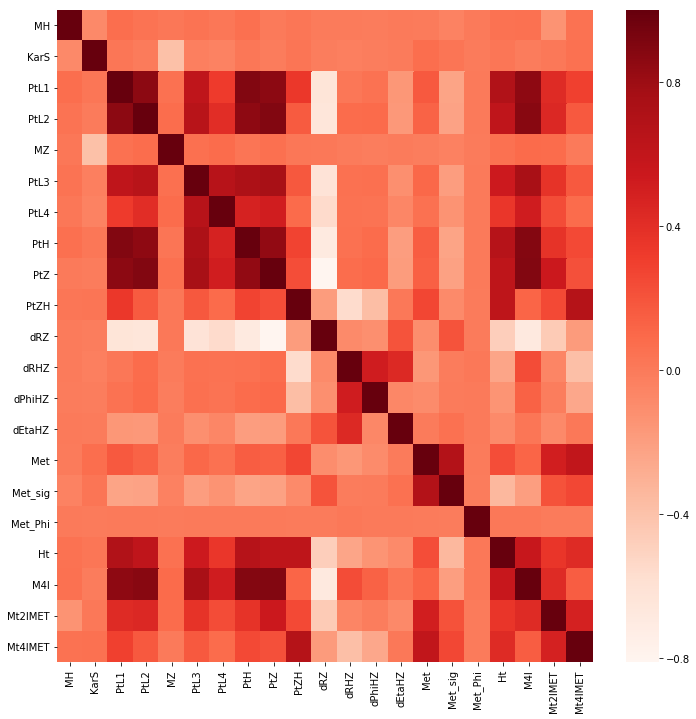

In [20]:
plt.figure(figsize=(12, 12))
cor = dataSignal.corr()
cor.style.set_precision(2)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

figure_fig.savefig('../figure/0819/corr_sig.pdf', format='pdf', dpi=500)

plt.show()

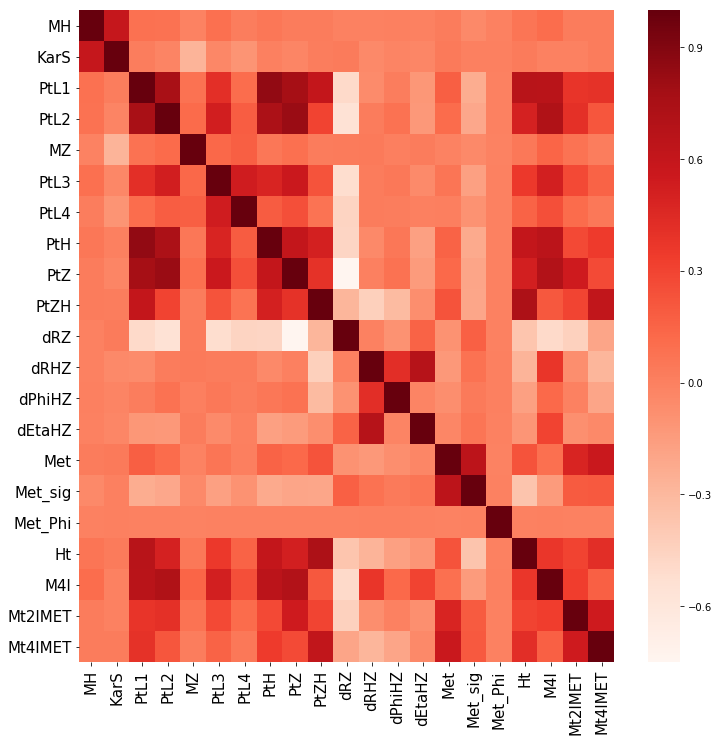

In [21]:
dataBackground = pd.DataFrame(data=backgroundArray[:, 2:], columns=["MH","KarS","PtL1","PtL2","MZ","PtL3","PtL4","PtH","PtZ","PtZH","dRZ","dRHZ","dPhiHZ","dEtaHZ","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
plt.figure(figsize=(12, 12))
cor = dataBackground.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
figure_fig.savefig('../figure/0819/corr_bkg.pdf', format='pdf', dpi=500)
plt.show()

In [22]:
print(signalArray)

[[1.02972879e-04 0.00000000e+00 1.26325469e+02 ... 2.58855319e+02
  9.68744012e+01 9.45111893e+01]
 [1.11745701e-04 0.00000000e+00 1.22227364e+02 ... 3.02104405e+02
  6.74024163e+01 3.31930904e+01]
 [1.12758470e-04 0.00000000e+00 1.20435555e+02 ... 9.63660383e+02
  1.61516479e+02 1.72498370e+01]
 ...
 [1.33198970e-06 1.00000000e+00 1.24675325e+02 ... 2.25321387e+02
  3.76822945e+01 9.81297137e+00]
 [1.21642818e-05 1.00000000e+00 1.23379894e+02 ... 2.68476686e+02
  2.51045203e+01 1.10452094e+01]
 [1.05916127e-05 1.00000000e+00 1.21102678e+02 ... 4.05909171e+02
  4.90828318e+01 6.76514761e+01]]


In [23]:
print(signalArray[:,2])

[126.32546926 122.22736428 120.43555458 ... 124.67532499 123.37989434
 121.10267778]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [24]:
signalSample2=signalArray#[(signalArray[:,1]==1)]
backgroundSample2=backgroundArray#[(backgroundArray[:,1]==1)]#[(abs(backgroundArray[:,7])<75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]

In [25]:
print(len(signalSample2))
print(len(backgroundSample2))

21332
68235


In [26]:
signalNum=len(signalSample2)
backgroundNum=len(backgroundSample2)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample2[:,0]))
print("background yield after cut is:",sum(backgroundSample2[:,0]))
SBratio=sum(signalSample2[:,0])/sum(backgroundSample2[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample2[:,0])
BkgYield=sum(backgroundSample2[:,0])

signal event number after cut is:  21332
background event number after cut is: 68235
signal yield after cut is:  0.6112788015442353
background yield after cut is: 114.59319235710277
S/B ratio is:  0.005334337834304577


In [27]:
signalSample=signalSample2#[(signalSample2[:,12]>80000)&(signalSample2[:,12]<150000)&(signalSample2[:,14]<2.8)]
backgroundSample=backgroundSample2#[(backgroundSample2[:,12]>80000)&(backgroundSample2[:,12]<150000)&(backgroundSample2[:,14]<2.8)]

In [28]:
dataNormal=np.vstack((signalSample,backgroundSample))

In [29]:
print(dataNormal)

[[1.02972879e-04 0.00000000e+00 1.26325469e+02 ... 2.58855319e+02
  9.68744012e+01 9.45111893e+01]
 [1.11745701e-04 0.00000000e+00 1.22227364e+02 ... 3.02104405e+02
  6.74024163e+01 3.31930904e+01]
 [1.12758470e-04 0.00000000e+00 1.20435555e+02 ... 9.63660383e+02
  1.61516479e+02 1.72498370e+01]
 ...
 [4.26221409e-01 0.00000000e+00 1.42376803e+02 ... 2.34874130e+02
  6.33139275e+01 1.43783704e+02]
 [3.49885668e-01 0.00000000e+00 1.15695806e+02 ... 2.26984546e+02
  3.34987661e+01 3.85812936e+01]
 [2.92057358e-01 0.00000000e+00 1.45946629e+02 ... 4.79284085e+02
  1.14256744e+00 3.20266968e+01]]


In [30]:
print(len(signalSample))
print(len(backgroundSample))

21332
68235


In [31]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample[:,0]))
print("background yield after cut is:",sum(backgroundSample[:,0]))
SBratio=sum(signalSample[:,0])/sum(backgroundSample[:,0])
print("S/B ratio is: ",SBratio)
SigYield1=sum(signalSample[:,0])
BkgYield1=sum(backgroundSample[:,0])

signal event number after cut is:  21332
background event number after cut is: 68235
signal yield after cut is:  0.6112788015442353
background yield after cut is: 114.59319235710277
S/B ratio is:  0.005334337834304577


Split datasets into training and testing subsets

In [32]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  17065
testing signal events number is:  4267
training background events number is:  54588
testing background events number is:  13647


In [33]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain1=signalSample[signal_train_row,:]
signalTest1=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain1=backgroundSample[background_train_row,:]
backgroundTest1=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain1=np.concatenate((label_signal_train,signalTrain1),axis=1)
backgroundTrain1=np.concatenate((label_background_train,backgroundTrain1),axis=1)
signalTrain=signalTrain1[(signalTrain1[:,1]>0)]
backgroundTrain=backgroundTrain1[(backgroundTrain1[:,1]>0)]
signalTest1=np.concatenate((label_signal_test,signalTest1),axis=1)
backgroundTest1=np.concatenate((label_background_test,backgroundTest1),axis=1)
signalTest=signalTest1[(signalTest1[:,1]>0)]
backgroundTest=backgroundTest1[(backgroundTest1[:,1]>0)]
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)
ratio1=sum(signalTest[:,1])/sum(backgroundTest[:,1])
signalTest[:,1]=signalTest[:,1]/ratio1

[[0.00000000e+00 4.90567101e-03 0.00000000e+00 ... 2.56919625e+02
  7.35609110e+01 8.14843423e+01]
 [0.00000000e+00 6.00951533e-04 0.00000000e+00 ... 5.14776815e+02
  9.73381294e+01 1.04514598e+02]
 [0.00000000e+00 7.86337411e-03 1.00000000e+00 ... 2.81659591e+02
  1.32050062e+01 8.12407315e+01]
 ...
 [0.00000000e+00 3.45791150e-03 1.00000000e+00 ... 2.43072597e+02
  5.93415355e+01 4.36684860e+01]
 [0.00000000e+00 6.59255791e-03 0.00000000e+00 ... 1.79844078e+03
  3.17187918e+02 3.81306953e+02]
 [0.00000000e+00 2.92057358e-01 0.00000000e+00 ... 4.79284085e+02
  1.14256744e+00 3.20266968e+01]]
0.003997121384297377


In [34]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,4:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,4:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(65366, 20) dtype=float32>

Signal and background training sets should have same yield in training

(array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

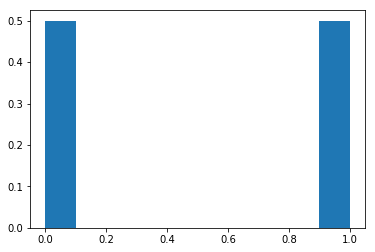

In [35]:
dataTrainWeight=dataTrainWeight/sum(dataTrainWeight)
plt.hist(dataTrain[:,0],weights=dataTrainWeight)

In [36]:
average_train_weight=dataTrainWeight.mean()

(array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

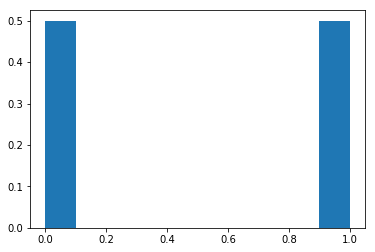

In [37]:
dataTestWeight=dataTestWeight/sum(dataTestWeight)
plt.hist(dataTest[:,0],weights=dataTestWeight)

In [38]:
average_test_weight=dataTestWeight.mean()

Build model

In [39]:
print(guass_normal(signalSample[:,3:],dataNormal[:,3:],dataNormal[:,0]))

[[-0.85089053 -0.56842454 -0.14039698 ... -0.39647674  1.41323531
   1.46244155]
 [-0.82498964  0.56033611  1.37217551 ... -0.04034792  0.61408345
  -0.20414162]
 [-0.78254302  4.67528477  7.30778028 ...  5.40714636  3.16604691
  -0.63746814]
 ...
 [-0.85711043 -0.85753209 -0.56918235 ... -0.67260742 -0.19179681
  -0.83959696]
 [-0.84231523 -0.34157801 -0.71231773 ... -0.31725088 -0.53285126
  -0.80610559]
 [-0.74275415  1.46927701  0.90769694 ...  0.81441856  0.11733611
   0.73241327]]


In [40]:
dataTrainSample1=guass_normal(dataTrainSample,dataNormal[:,3:],dataNormal[:,0])
dataTestSample1=guass_normal(dataTestSample,dataNormal[:,3:],dataNormal[:,0])

In [41]:
signalSample1=signalSample[(signalSample[:,2]>120.0)&(signalSample[:,2]<130.0)]
backgroundSample1=backgroundSample[(backgroundSample[:,2]>120.0)&(backgroundSample[:,2]<130.0)]
SBratio=sum(signalSample1[:,0])/sum(backgroundSample1[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample1[:,0])
BkgYield=sum(backgroundSample1[:,0])

S/B ratio is:  0.01593524662258117


In [42]:
signalSample2=guass_normal(signalSample1[:,3:],dataNormal[:,3:],dataNormal[:,0])
backgroundSample2=guass_normal(backgroundSample1[:,3:],dataNormal[:,3:],dataNormal[:,0])

(array([ 1889.,  1815.,  1838.,  1836.,  2018.,  2291.,  2816.,  3935.,
         6190., 14264., 15266.,  4938.,  2425.,  1455.,   859.,   615.,
          400.,   285.,   165.,    66.]),
 array([-3.08617088, -2.746251  , -2.40633112, -2.06641123, -1.72649135,
        -1.38657147, -1.04665158, -0.7067317 , -0.36681182, -0.02689193,
         0.31302795,  0.65294784,  0.99286772,  1.3327876 ,  1.67270749,
         2.01262737,  2.35254725,  2.69246714,  3.03238702,  3.3723069 ,
         3.71222679]),
 <a list of 20 Patch objects>)

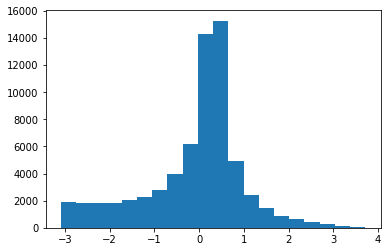

In [43]:
plt.hist(dataTrainSample1[:,11],bins=20)

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     #optimizer=SGD(lr=0.01, momentum=0.5, decay=0.8, nesterov=True),
     metrics=["acc"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=100, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
plt.hist(backgroundNN,bins=20,weights=backgroundSample[:,0])

In [ ]:
plt.hist(signalNN,bins=20,weights=signalSample[:,0])

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('../NN_model/0716/_NNmodel_region4.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
         input_dim=21))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)

In [ ]:
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [ ]:
cuda.select_device(0)
cuda.close()

In [44]:
drv.init()
device = torch.device("cuda:0")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float).to(device)
WeightTensor=torch.tensor((dataTrainWeight), dtype=torch.float).to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float).to(device)
dataTestTensor=torch.tensor(dataTestSample1,dtype=torch.float).to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=1000, shuffle=False)
TestWeightTensor=torch.tensor(dataTestWeight,dtype=torch.float).to(device)
test_y_tensor=torch.tensor(dataTestLabel, dtype=torch.float).to(device)
TestDataset = TensorDataset((TestWeightTensor), dataTestTensor, test_y_tensor)
TestLoader = DataLoader(TestDataset, batch_size=500, shuffle=False)

In [45]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 200)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(200,200)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(200, 200)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(200, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [46]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [47]:
def custom_loss(y_pred,y,weights):
    loss=torch.mean((y*torch.exp(5*(1-y_pred))+(1-y)*torch.exp(5*(y_pred)))*weights)
    return loss

In [48]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data, target, sample_weight
        
        optimizer.zero_grad()
        data=data.squeeze()
        output = model(data)
        loss_function.weight = sample_weight/average_train_weight
        #my_weight=sample_weight/sample_weight.mean()
        output=output.reshape(-1)
        loss = loss_function(output, target)
        #loss = custom_loss(output, target,my_weight)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

In [49]:
def eval_train(model,device,input_loader,loss_function):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, data, target) in enumerate(input_loader):
            batch_n=batch_n+1
            data, target,sample_weight = data, target, sample_weight
            output = model(data)
            output=output.reshape(-1)
            loss_function.weight = sample_weight/average_test_weight
            loss = loss_function(output, target)
            average_loss=average_loss+loss.item()
    return(average_loss/batch_n)

In [50]:
model = Net().to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=20, out_features=200, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=200, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [51]:
loss_fn =nn.BCELoss().cuda()
#loss_fn=custom_loss()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [52]:
lowest_loss=9999
counter=0
best_epoch=0
pat=5
loss_np=np.zeros((300,1))
loss_test_np=np.zeros((300,1))
for epoch in range(1, 300):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        loss_eval_epoch=(4.0*loss_test_epoch+loss_epoch)/5.0
        if(loss_eval_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_eval_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break
        

Train Epoch: 1 [0/65366 (0%)]	Loss: 0.712545
Train Epoch: 1 [10000/65366 (15%)]	Loss: 0.674815
Train Epoch: 1 [20000/65366 (30%)]	Loss: 0.553091
Train Epoch: 1 [30000/65366 (45%)]	Loss: 0.564461
Train Epoch: 1 [40000/65366 (61%)]	Loss: 0.586947
Train Epoch: 1 [50000/65366 (76%)]	Loss: 0.459258
Train Epoch: 1 [60000/65366 (91%)]	Loss: 0.544382
Average loss in epoch  1  is:  0.5693260178421483
Train Epoch: 2 [0/65366 (0%)]	Loss: 0.531118
Train Epoch: 2 [10000/65366 (15%)]	Loss: 0.580564
Train Epoch: 2 [20000/65366 (30%)]	Loss: 0.513507
Train Epoch: 2 [30000/65366 (45%)]	Loss: 0.521023
Train Epoch: 2 [40000/65366 (61%)]	Loss: 0.549377
Train Epoch: 2 [50000/65366 (76%)]	Loss: 0.455443
Train Epoch: 2 [60000/65366 (91%)]	Loss: 0.519883
Average loss in epoch  2  is:  0.5155363417032993
Train Epoch: 3 [0/65366 (0%)]	Loss: 0.516634
Train Epoch: 3 [10000/65366 (15%)]	Loss: 0.543758
Train Epoch: 3 [20000/65366 (30%)]	Loss: 0.504262
Train Epoch: 3 [30000/65366 (45%)]	Loss: 0.524082
Train Epoch: 3 

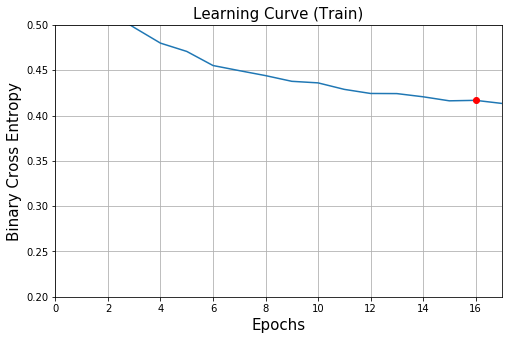

In [53]:
loss_train=loss_np[:best_epoch+pat,0]
train_step=range(1,best_epoch+pat+1)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (Train)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+pat)
    ax.set_ylim(0.2,0.5)
    return l

def gen_dot():
    for i in range(1,best_epoch+pat):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figure/0823/loss-all-train.gif', writer='imagemagick', fps=30)
plt.show()

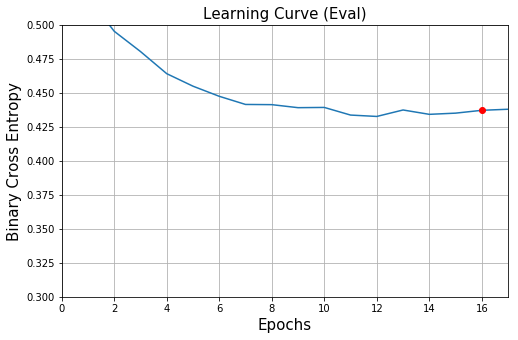

In [54]:
loss_train=loss_test_np[:best_epoch+pat,0]
train_step=range(1,best_epoch+pat+1)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (Eval)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+pat)
    ax.set_ylim(0.3,0.5)
    return l

def gen_dot():
    for i in range(1,best_epoch+pat):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figure/0823/loss-all-test.gif', writer='imagemagick', fps=30)
plt.show()

In [55]:
del TrainLoader
torch.cuda.empty_cache()
del TrainDataset
torch.cuda.empty_cache()
#del dataTrainTensor
#torch.cuda.empty_cache()
del WeightTensor
torch.cuda.empty_cache()

In [56]:
def eval_pytorch(model,device,input_loader):
    output_numpy=[1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score=model(data1)
            del data1
            score_np=score.data.cpu().numpy()
            output_numpy=np.vstack((output_numpy,score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

In [57]:
signalTensor = torch.tensor(signalSample2, dtype=torch.float, device=device)
signalLoader=DataLoader(signalTensor,batch_size=10000, shuffle=False)

[0.85240084 0.82065982 0.97980267 ... 0.81099463 0.68866676 0.85220408]
17695


(array([0.00110836, 0.00216768, 0.00244141, 0.00307021, 0.0042367 ,
        0.00371246, 0.00510445, 0.00645838, 0.00755429, 0.01014973,
        0.01243935, 0.01546751, 0.02174011, 0.03159762, 0.04475978,
        0.06399323, 0.08721989, 0.09985542, 0.06901857, 0.01766046]),
 array([2.56252097e-04, 4.94616441e-02, 9.86670361e-02, 1.47872428e-01,
        1.97077820e-01, 2.46283212e-01, 2.95488604e-01, 3.44693996e-01,
        3.93899388e-01, 4.43104780e-01, 4.92310172e-01, 5.41515564e-01,
        5.90720956e-01, 6.39926348e-01, 6.89131740e-01, 7.38337132e-01,
        7.87542524e-01, 8.36747916e-01, 8.85953308e-01, 9.35158700e-01,
        9.84364092e-01]),
 <a list of 20 Patch objects>)

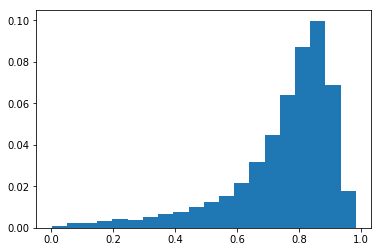

In [58]:
sigScore = eval_pytorch(model,device,signalLoader)
sigScore=sigScore[1:,0]
print(sigScore)
print(len(sigScore))
plt.hist(sigScore,bins=20,weights=signalSample1[:,0])

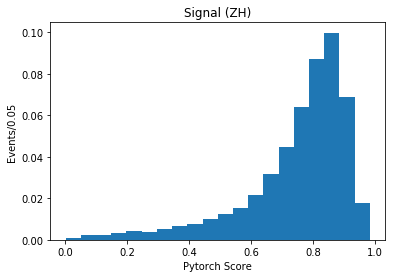

In [59]:
plt.hist(sigScore,bins=20,weights=signalSample1[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
plt.title("Signal (ZH)")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0823/NN-all-sig.pdf', format='pdf', dpi=500)
plt.show()

In [60]:
bakTensor= torch.tensor(backgroundSample2, dtype=torch.float,device=device)
backgroundLoader=DataLoader(bakTensor,batch_size=10000, shuffle=False)
bakScore = eval_pytorch(model,device,backgroundLoader)

In [61]:
bakScore=bakScore[1:,0]
print(bakScore)
print(len(bakScore))

[0.02157484 0.28726682 0.02471495 ... 0.20307866 0.03287203 0.45170403]
19016


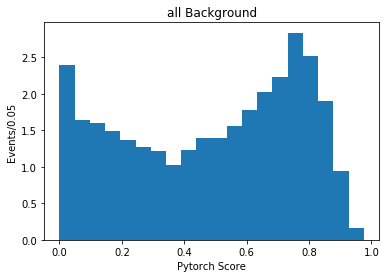

In [62]:
plt.hist(bakScore,bins=20,weights=backgroundSample1[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
plt.title("all Background")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0823/NN-all-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
gc.collect()

In [63]:
signalFile.Close()
backgroundFile.Close()

sigFile=TFile.Open("../sample-0718/bkg_fake.root", "update")
bkgFile=TFile.Open("../sample-0718/bkg_diboson.root","update")
sigTree=sigFile.Get("ntup")
bkgTree=bkgFile.Get("ntup")
sR1BDT=array("f",[0])
bR1BDT=array("f",[0])
sigRegion1BDTBranch=sigTree.Branch("BDT_Region1",sR1BDT,"BDT_Region1/F")
bkgRegion1BDTBranch=bkgTree.Branch("BDT_Region1",bR1BDT,"BDT_Region1/F")


ReferenceError: attempt to access a null-pointer

SysError in <TFile::TFile>: file ../sample-0718/bkg_fake.root can not be opened (No such file or directory)
SysError in <TFile::TFile>: file ../sample-0718/bkg_diboson.root can not be opened (No such file or directory)


In [ ]:
i=0
for (scoreR1,scoreR2,scoreR3,scoreR4) in zip(sigRegion1BDTScore,sigRegion2BDTScore,sigRegion3BDTScore,sigRegion4BDTScore):
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    sR1BDT[0]=scoreR1
    sR2BDT[0]=scoreR2
    sR3BDT[0]=scoreR3
    sR4BDT[0]=scoreR4
    sigRegion1BDTBranch.Fill()
    sigRegion2BDTBranch.Fill()
    sigRegion3BDTBranch.Fill()
    sigRegion4BDTBranch.Fill()
    
sigTree.Write()
sigFile.Write()
sigFile.Close()

In [64]:
dataTrainTensor= torch.tensor(dataTrainSample1, dtype=torch.float,device=device)
dataTrainLoader=DataLoader(dataTrainTensor,batch_size=100, shuffle=False)
TrainScore = eval_pytorch(model,device,dataTrainLoader)
TrainScore=TrainScore[1:,0]

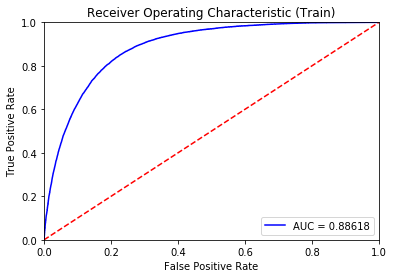

In [65]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,TrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Train)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0823/roc-4m-train-NN.pdf', format='pdf', dpi=500)
plt.show()

In [66]:
dataTestTensor= torch.tensor(dataTestSample1, dtype=torch.float,device=device)
dataTestLoader=DataLoader(dataTestTensor,batch_size=100, shuffle=False)
TestScore = eval_pytorch(model,device,dataTestLoader)
TestScore=TestScore[1:,0]

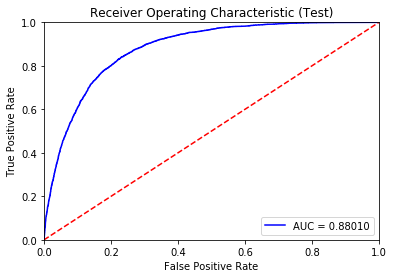

In [67]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,TestScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Test)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0823/roc-4m-test-NN.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
torch.save(model,"../NN_model/region4-pytorch.pickle.dat")

In [ ]:
model.save_state_dict('../NN_model/region4-pytorch.pt')

In [ ]:
torch.save(model.state_dict(),'../NN_model/hmumu-pytorch-0823-all.pt')

In [ ]:
del bakTensor
torch.cuda.empty_cache()

In [ ]:
cuda.select_device(0)
cuda.close()

In [ ]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample[:,3:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample[:,3:],feature_names=varName)
param = {'max_depth': 4, 'eta':0.1,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]
#eta_list=[0.1]*10+[0.05]*20+[0.02]*40+[0.01]*930

In [ ]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

In [ ]:
GBDT=pickle.load(open("../BDT_model/GBDT_HH_region3-0.01.pickle.dat", "rb"))

In [ ]:
xgb.plot_importance(GBDT,importance_type="gain")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-gain.pdf', format='pdf', dpi=500)

In [ ]:
xgb.plot_importance(GBDT,importance_type="weight")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-weight.pdf', format='pdf', dpi=500)

In [ ]:
xgb.plot_importance(GBDT,importance_type="cover")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-coverage.pdf', format='pdf', dpi=500)

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,range=[0.9, 1.0],weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-bkg-high.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BDTBackground1=xgb.DMatrix(backgroundArray[:,3:],feature_names=varName)
BackgroundScore1=GBDT.predict(BDTBackground1)
plt.hist(BackgroundScore1,bins=10,range=[0.9,1.0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

In [ ]:
plt.hist(SignalScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-sig.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plot_tree(GBDT, num_trees=4)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/roc-region4-train-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("../BDT_model/0716/GBDT_HH_region4_01.pickle.dat", "wb"))

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/roc-region4-test.pdf', format='pdf', dpi=500)
plt.show()

In [68]:
drv.init()
mod=SourceModule("""
__global__ void func1(double *a, double *b, double *c,double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     if(a[i]>thre){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func1=mod.get_function("func1") 

In [69]:
def cuda_sum(nump1,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func1(drv.InOut(num1),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [ ]:
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.9)
resS=cuda_sum(SignalScore,signalSample[:,0],0.9)
SBratio1=resS/resB
Sig1=resS/sqrt(resB)
print("If cut BDT at 0.9, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio1," Significance is: ",Sig1)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.95)
resS=cuda_sum(SignalScore,signalSample[:,0],0.95)
SBratio2=resS/resB
Sig2=resS/sqrt(resB)
print("If cut BDT at 0.95, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio2," Significance is: ",Sig2)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.975)
resS=cuda_sum(SignalScore,signalSample[:,0],0.975)
SBratio3=resS/resB
Sig3=resS/sqrt(resB)
print("If cut BDT at 0.975, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio3," Significance is: ",Sig3)

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
print(eff)
for i in np.arange(0,1,0.001):
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if((abs(ratio-0.8)<0.01)|(abs(ratio-0.7)<0.001)|(abs(ratio-0.6)<0.01)|(abs(ratio-0.5)<0.01)|(abs(ratio-0.4)<0.01)):
        print("sig Eff: ",ratio," and BDT cut is: ",i)
    

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(BackgroundScore,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(SignalScore,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)
    
    

In [ ]:
plt.hist(bakScore,bins=20,weights=backgroundSample[:,0])

In [ ]:
plt.hist(sigScore,bins=20,weights=signalSample[:,0])

In [70]:
i=0.1
eff=(0.98,0.9,0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=8):
        break
    resS=cuda_sum(sigScore,signalSample1[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(bakScore,backgroundSample1[:,0],BDT_cut)
            resS=cuda_sum(sigScore,signalSample1[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut NN at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

(0.98, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3)
If cut NN at  0.211 signal yield is: [0.49947313]  Eff is: [0.97982862]  background yield is: [24.35428558]  Eff is:  [0.76132865]  S/B ratio is:  [0.02050863]  Significance is:  [0.10121023]
If cut NN at  0.513 signal yield is: [0.45874237]  Eff is: [0.89992609]  background yield is: [16.69573184]  Eff is:  [0.52191796]  S/B ratio is:  [0.02747663]  Significance is:  [0.11227062]
If cut NN at  0.652 signal yield is: [0.40767195]  Eff is: [0.79974]  background yield is: [11.98822398]  Eff is:  [0.37475862]  S/B ratio is:  [0.03400603]  Significance is:  [0.11774254]
If cut NN at  0.72 signal yield is: [0.3566976]  Eff is: [0.69974237]  background yield is: [8.90319502]  Eff is:  [0.27831888]  S/B ratio is:  [0.040064]  Significance is:  [0.11954385]
If cut NN at  0.766 signal yield is: [0.30631913]  Eff is: [0.60091371]  background yield is: [6.42143467]  Eff is:  [0.20073766]  S/B ratio is:  [0.0477026]  Significance is:  [0.12088101]
If cut N

In [ ]:
print(len(sigScore[(sigScore>0.962)]))

In [ ]:
print(len(bakScore[(bakScore>0.962)]))

In [ ]:
DYFile= TFile.Open("../samples-train/tree_zmm_modify.root")
dibosonFile= TFile.Open("../samples-train/tree_diboson_modify.root")
ttbarFile= TFile.Open("../samples-train/tree_ttbar_modify.root")

In [ ]:
DYTree=DYFile.Get("tree_NOMINAL")
dibosonTree=dibosonFile.Get("tree_NOMINAL")
ttbarTree=ttbarFile.Get("tree_NOMINAL")

In [ ]:
DYArray=DYTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
dibosonArray=dibosonTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
ttbarArray=ttbarTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])


In [ ]:
DYSample1=DYArray[(DYArray[:,1]>120.0)&(DYArray[:,1]<130.0)]
ttbarSample1=ttbarArray[(ttbarArray[:,1]>120.0)&(ttbarArray[:,1]<130.0)]
dibosonSample1=dibosonArray[(dibosonArray[:,1]>120.0)&(dibosonArray[:,1]<130.0)]

In [ ]:
print(len(dibosonSample1))

In [ ]:
DYSample2=guass_normal(DYSample1[:,2:],dataNormal[:,2:])
dibosonSample2=guass_normal(dibosonSample1[:,2:],dataNormal[:,2:])
ttbarSample2=guass_normal(ttbarSample1[:,2:],dataNormal[:,2:])

In [ ]:
DYTensor= torch.tensor(DYSample2, dtype=torch.float,device=device)
DYLoader=DataLoader(DYTensor,batch_size=100, shuffle=False)
DYScore = eval_pytorch(model,device,DYLoader)
DYScore=DYScore[1:,0]

In [ ]:
ttbarTensor= torch.tensor(ttbarSample2, dtype=torch.float,device=device)
ttbarLoader=DataLoader(ttbarTensor,batch_size=100, shuffle=False)
ttbarScore = eval_pytorch(model,device,ttbarLoader)
ttbarScore=ttbarScore[1:,0]

In [ ]:
dibosonTensor= torch.tensor(dibosonSample2, dtype=torch.float,device=device)
dibosonLoader=DataLoader(dibosonTensor,batch_size=100, shuffle=False)
dibosonScore = eval_pytorch(model,device,dibosonLoader)
dibosonScore=dibosonScore[1:,0]

In [ ]:
print(cuda_sum(dibosonScore,dibosonSample1[:,0],0.962))

In [ ]:
print(len(DYScore[(DYScore>0.962)]))

In [ ]:
for i in np.arange(0,1,0.001):
    resB=cuda_sum(BackgroundScore,backgroundSample[:,0],i)
    print(resB/BkgYield)
    

In [ ]:
print("If cut at 0.9,   improvment is: ",SBratio1/SBratio)
print("If cut at 0.95,  improvment is: ",SBratio2/SBratio)
print("If cut at 0.975, improvment is: ",SBratio3/SBratio)